<a href="https://colab.research.google.com/github/gokmenkilic/ML-Intro/blob/gk%2Ftests/Healthcare_Equilibrium_State_Prediction_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Equilibrium thermochemistry for gas regression

In this notebook, we attempt to build a neural network to calculate the equilibrium thermochemistry for gas under various physical conditions ahead of time.

Regression models attempt to map from some variables ($x$) to some continuous variables ($y$) and are typically used when either no theoretical model $y=f(x)$ is known or $f(x)$ is expensive to compute.

Since most gas cooling in astrophysical contexts comes from molecules radiating energy away, their abundances essentially set the cooling rate. Since the temperature affects how the gas evolves dynamically, any physics simulation of processes such as star formation requires a method of accurately calculating the chemistry of the gas.

Unfortunately, accurately calculating the temperature and chemistry (henceforth thermochemistry) of a gas can be computationally expensive. Many approaches such as simplifying chemical networks to only the most important species and reactions or assuming equilibrium are used to decrease the cost of these calculations. However, even these can fail for large simulations where an object is broken up into many parts which all require a thermochemical calculation.

As the relationship between $x$ and $y$ becomes more complex, more complex models are required. In this notebook, we will consider a complex case where a deep neural network is required to produce an adequate model.


In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import os
import urllib.request
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)


Using TensorFlow v2.19.0


## Data Setup & Google Colab Environment

The dataset is hosted publicly by DiRAC on COSMA. **Please make sure you run the cell below to download the data.**

To access the data from COSMA, you need to:

1. Run the first cell;
2. It will create a folder called sciml-workshop-data.
3. It will download the necessary HDF5 files directly into that folder.
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# data setup configuration
data_path = 'sciml-workshop-data'
full_dir = os.path.join(data_path, 'NHS')
os.makedirs(full_dir, exist_ok=True)

base_url = "https://virgodb.cosma.dur.ac.uk/public/dc-kili1/sciml-workshop-data/NHS/"
files_to_download = ["equilibrium-small-network.hdf"]

In [3]:
for filename in files_to_download:
    path = os.path.join(full_dir, filename)

    if not os.path.exists(path):
        urllib.request.urlretrieve(base_url + filename, path)

---

# 1. Load the dataset

We start by loading the dataset taken from [Chemulator - Holdship et al. 2020](https://ui.adsabs.harvard.edu/abs/2021A%26A...653A..76H/abstract).

The full **Chemulator** dataset contains the abundances and temperature of simulated astrophysical gases as a function of time when exposed to different conditions. The conditions are described by four input variables:

- Gas density (`Density`)
- Local UV field strength (`local_uv`)
- Local cosmic ray ionization rate (`zeta`)
- Ratio of the abundance of metals in this gas to the sollar abundance of metal (`metallicity`)

In this work, we use a slimmed down dataset which contains the equilibrium abundances and temperature for each set of conditions. We will attempt to predict the equilibrium gas temperature.

Equilibrium modelling is common in astrophysics. For example, stars in the process of forming tend to be surrounded by disks of gas and dust and the equilibrium state of such disks are often modelled. This is done by repeatedly solving the physical equilbrium for a disk with a given temperature distribtion and then the thermochemical equilibrium of a disk with fixed physics. By iterating back and forth, we eventually find an overall equilbrium between chemistry and physics. Such an iterative procedure would made much more efficient by making the chemical equilibrium quick to compute.

The data are stored in the hdf file 'NHS/equilibrium-small-network.hdf'. In addition local_uv can be calculated by radfield$\cdot$exp(-3.02$\cdot$av)


**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# load dataset
X_train=pd.read_hdf(join(data_path, 'NHS/equilibrium-small-network.hdf'),key="df")
X_train['local_uv']=X_train['radfield']*np.exp(-3.02*X_train['av'])
```
    
</p>
</details>

In [4]:
# load dataset
X_train=pd.read_hdf(join(data_path, 'NHS/equilibrium-small-network.hdf'),key="df")
X_train['local_uv']=X_train['radfield']*np.exp(-3.02*X_train['av'])

In [5]:
#grab the features, everything else is a possible target for regression
features=['Density', 'local_uv', 'zeta', 'metallicity']
labels=['gasTemp']

#we assume a minimum value below which a variable is basically zero
#we also know some variables vary over orders of magnitude but all scales are equally important
#so we log those variables.
X_train[features]=np.where(X_train[features]<1e-5,1e-5,X_train[features])
X_train[['Density', 'local_uv', 'zeta']]=np.log10(X_train[['Density', 'local_uv', 'zeta']])
X_train[labels]=np.where(X_train[labels]<1e-20,1e-20,X_train[labels])
X_train[labels]=np.log10(X_train[labels])

#data normalisation to set mean 0 std 1
scaler = StandardScaler()
scaler.fit(X_train[features])

X_train,X_test,y_train,y_test=train_test_split(X_train[features],X_train[labels],test_size=0.25)

---

# 2. Build the network

We will build a simple linear regression model and a fully-connected neural network to compare their results. The output is continuous values and so we use 'mean squared error loss'.



### Linear regression model

We use linear regression model from sklearn

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
model=LinearRegression(normalize=True)
model.fit(X_train,y_train)
```
    
</p>
</details>

In [8]:
# Apply the scaler transformation
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model=LinearRegression()
model.fit(X_train,y_train)


LinearRegression()

In [9]:
mse=mean_squared_error(y_test,model.predict(X_test))
print('mse on the test set: {:.2f}'.format(mse))

mse on the test set: 0.21


### Build a Neural Network

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
def create_model(layers,n_targets,activation="swish",loss="mse"):
    # build the network architecture
    model = Sequential()
    model.add(Input(len(features)))
    for nodes in layers:
        model.add(Dense(nodes, activation=activation))
    model.add(Dense(n_targets, activation=activation))
    # optimizer, loss, metrics
    optimizer = keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer=optimizer,loss=loss)
    return model

layers=[512,512]
model=create_model(layers,n_targets = 1)

# print summary
model.summary()
```
    
</p>
</details>

In [11]:
def create_model(layers,n_targets,activation="swish",loss="mse"):
    # build the network architecture
    model = Sequential()
    model.add(Input(shape=(len(features),)))
    for nodes in layers:
        model.add(Dense(nodes, activation=activation))
    model.add(Dense(n_targets, activation=activation))
    # optimizer, loss, metrics
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,loss=loss)
    return model

layers=[512,512]
model=create_model(layers,n_targets = 1)

# print summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,729 (1.01 MB)

 Trainable params: 265,729 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

We train the model using our training data and after each full pass of the training data (an epoch), we evaluate it on the test data. We repeat this process until the validation loss stops decreasing. Beyond this point, the model may start to overfit to the training data if the dataset is small or poorly sampled. To avoid this, we use Keras' early stopping to end training once the validation loss does not improve for two epochs.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# train the model

stopper=EarlyStopping( monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)
Normalised_X_train = scaler.transform(X_train)
Normalised_X_test = scaler.transform(X_test)
training_history = model.fit(Normalised_X_train, y_train, epochs=99, batch_size=32,
                             validation_data=(Normalised_X_test, y_test),callbacks=[stopper])
```
    
</p>
</details>

In [28]:
# train the model

stopper=EarlyStopping( monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)
Normalised_X_train = X_train
Normalised_X_test = X_test
training_history = model.fit(Normalised_X_train, y_train, epochs=99, batch_size=32,
                             validation_data=(Normalised_X_test, y_test),callbacks=[stopper])

Epoch 1/99
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4567 - val_loss: 0.0998
Epoch 2/99
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0948 - val_loss: 0.0892
Epoch 3/99
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0860 - val_loss: 0.0847
Epoch 4/99
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0817 - val_loss: 0.0825
Epoch 5/99
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0793 - val_loss: 0.0815
Epoch 6/99
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0777 - val_loss: 0.0808
Epoch 7/99
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0766 - val_loss: 0.0800
Epoch 8/99
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0757 - val_loss: 0.0792
Epoch 9/99
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0749 - val_loss: 0.0785
Epoch 10/99
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0743 - val_loss: 0.0781
Epoch 11/99
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0738 - val_loss: 0.0775
Epoch 12/99
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

---

# 3. Analyse results

After we've trained the model, we can plot the loss as a function of epoch. For this data, we can see that both losses decrease up to a point and then become stable. This is common when the dataset is large enough to prevent overfitting. At some point, the model learns the best relationship it can between the input and output variables and stops improving. Where the validation loss is much larger than the training loss, it is likely overfitting has occurred.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))

# plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Loss on training data')
plt.plot(training_history.history['val_loss'], label='Loss on test data')
plt.legend()
plt.title("Loss")
plt.show()
```
    
</p>
</details>

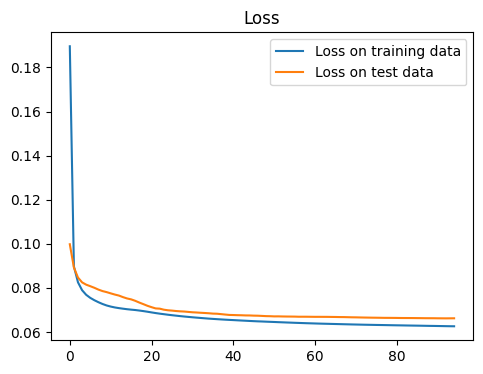

In [29]:
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))

# plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Loss on training data')
plt.plot(training_history.history['val_loss'], label='Loss on test data')
plt.legend()
plt.title("Loss")
plt.show()

The MSE is a useful metric and is a good summary of the general performance of the model. However, it can be instructive to look more closely at the predictions. In this section, we make a prediction of the temperature for every entry in our test data. We can then plot predicted vs real temperature and check to see if the performance of the model greatly varies depending on the temperature it is required to predict.

In [30]:
# use test images to predict
Normalised_X_test = X_test
y_pred = model.predict(Normalised_X_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [31]:
pred_df=pd.DataFrame({"x":y_test.values[:,0].flatten(),"y":y_pred[:,0].flatten()})

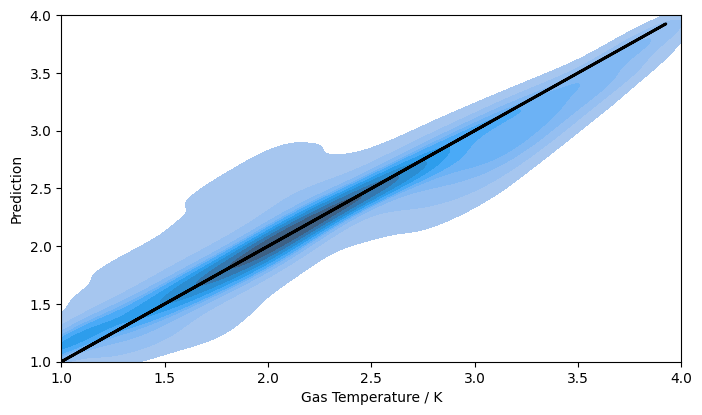

In [32]:
# get the indices of wrong predictions
fig,ax=plt.subplots(figsize=(8,4.5))
ax=sns.kdeplot(data=pred_df,x="x",y="y",ax=ax,clip=(1.0,4.0),fill=True)
ax.plot(y_test.values[:,0],y_test.values[:,0],color="black",lw=2)
settings=ax.set(xlabel="Gas Temperature / K",ylabel="Prediction",xlim=(1.0,4.0),ylim=(1.0,4.0))

We can further plot the MSE as a function of each parameter to see how the model performs depending on the area of parameter space.

In [36]:
X_test_df = pd.DataFrame(X_test, columns=features)
pred_df = pred_df.merge(X_test_df.round(2), left_index=True, right_index=True)
pred_df["error"] = (pred_df["y"] - pred_df["x"]).pow(2)

#pred_df=pred_df.merge(X_test.round(2).reset_index(),left_index=True,right_index=True)
#pred_df["error"]=(pred_df["y"]-pred_df["x"]).pow(2)

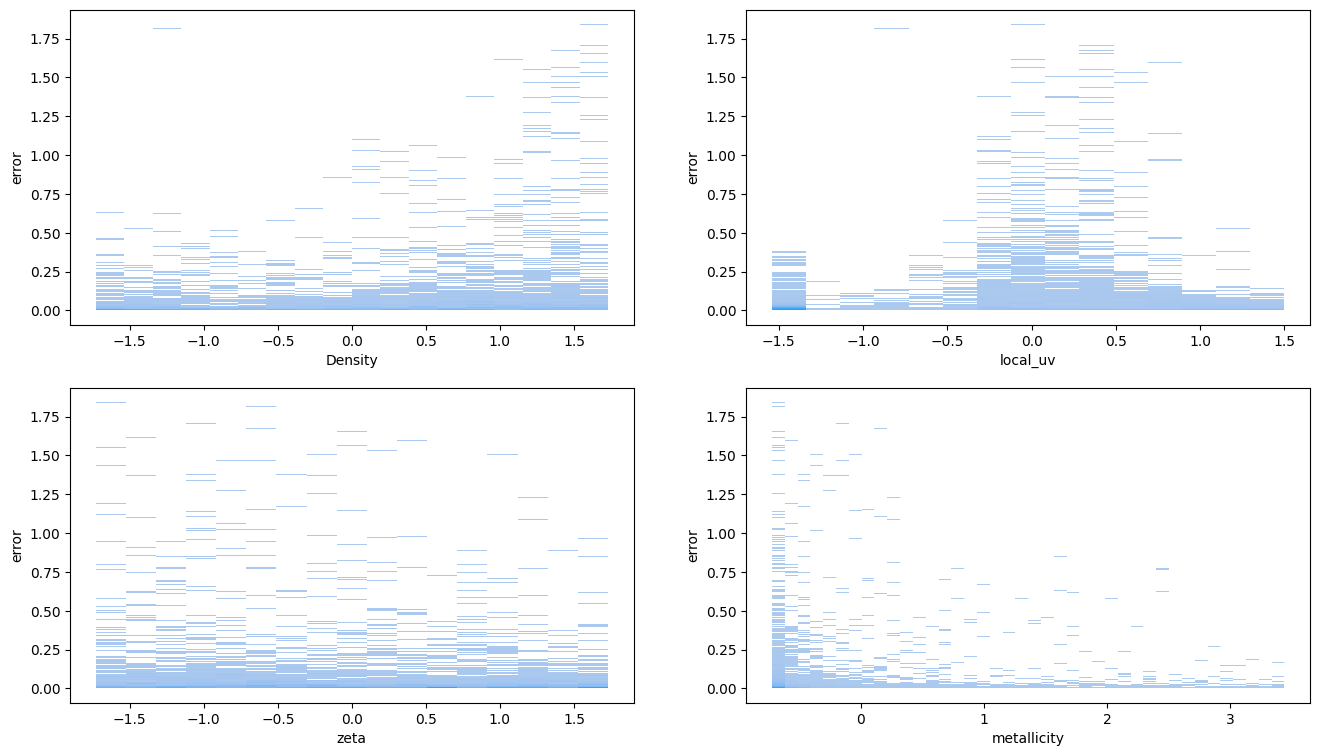

In [37]:
fig,axes=plt.subplots(2,2,figsize=(16,9))
axes=axes.flatten()
for i,feature in enumerate(features):
    sns.histplot(data=pred_df,x=feature,y="error",ax=axes[i])

---

# 4. Exercises

### Model Tuning

In this notebook, we simply produce a neural network and train it with no explanation for why the model hyperparameters were chosen. However, the ``create_model()`` function takes each major hyperparameter of the model as an input and can therefore be used to easily produce many models and test their performance.

Use a grid search to find optimal parameters for the model.

- Can you significantly improve the performance?
- Which activation function works best?
- How many layers are optimal?

### Extension
- Is MSE the best loss to use? How can you compare models trained with different losses?

In [38]:
layer_configs=[]#a list of lists
activation_functions=[]#a list of strings
performance_df=pd.DataFrame(columns=["layers","activation","MSE"])

#create a loop over your hyperparametrs

    #within that loop: create, train and evaluate a model then store its mse

